# Latent Case Study

We aim to investigate, in depth, a specific component identified as a latent component for a known task (IOI).

In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device, get_act_name

from attribution_methods import integrated_gradients, activation_patching, highlight_components, asymmetry_score
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Identify latent components in IOI task

In [17]:
clean_input = "When John and Mary went to the store, John gave a bottle of milk to "
corrupted_input = "When John and Mary went to the store, Mary gave a bottle of milk to "
labels = torch.tensor([
    [model.to_tokens("Mary", prepend_bos=False).item(), 
     model.to_tokens("John", prepend_bos=False).item()]
])

clean_tokens = model.to_tokens(clean_input, prepend_bos=False)
corrupted_tokens = model.to_tokens(corrupted_input, prepend_bos=False)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([0.5434], device='cuda:0')
Corrupted logit difference: tensor([0.5962], device='cuda:0')


In [25]:
mlp_corrupt_clean, attn_corrupt_clean = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)
mlp_clean_corrupt, attn_clean_corrupt = integrated_gradients(model, corrupted_tokens, corrupted_cache, clean_cache, logit_diff_metric, labels)


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-2.2724e-06], device='cuda:0')

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-2.5332e-06], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([-5.1409e-07], device='cuda:0')

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-8.1956e-07], device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([-1.3262e-06], device='cuda:0')

Error (delta) for blocks.2.mlp.hook_post attribution: tensor([1.4752e-06], device='cuda:0')

Error (delta) for blocks.3.attn.hook_result attribution: tensor([-5.4389e-07], device='cuda:0')

Error (delta) for blocks.3.mlp.hook_post attribution: tensor([4.3735e-06], device='cuda:0')

Error (delta) for blocks.4.attn.hook_result attribution: tensor([-1.0976e-06], device='cuda:0')

Error (delta) for blocks.4.mlp.hook_post attribution: tensor([-4.3437e-06], device='cuda:0')

Error (delta) for blocks.5.attn.hook_result at

In [76]:
mlp_asymmetry = asymmetry_score(mlp_corrupt_clean, mlp_clean_corrupt, is_ig=True)
attn_asymmetry = asymmetry_score(attn_corrupt_clean, attn_clean_corrupt, is_ig=True)

latent_attn, latent_attn_indices = highlight_components(attn_asymmetry)
latent_mlp, latent_mlp_indices = highlight_components(mlp_asymmetry)

In [78]:
torch.save(latent_attn, "results/case_study/latent_attn.pt")
torch.save(latent_mlp, "results/case_study/latent_mlp.pt")

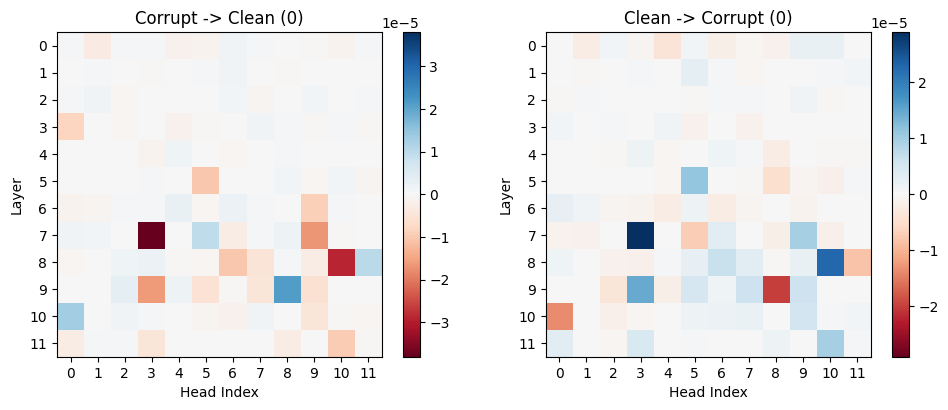

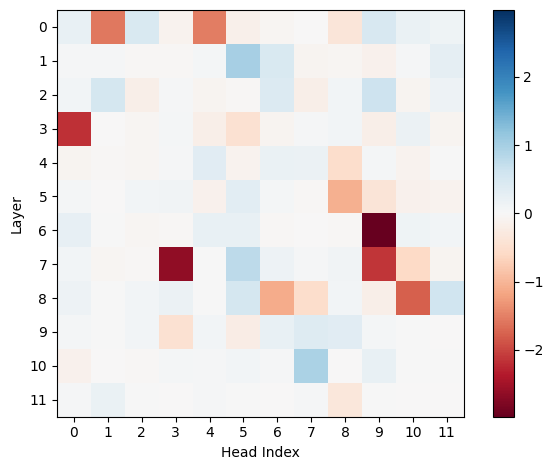

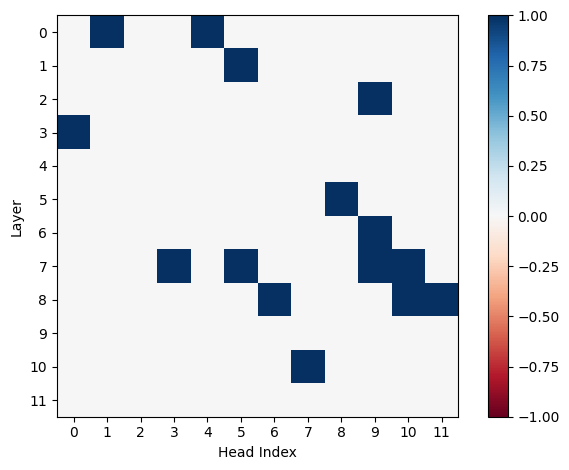

In [88]:
plot_attn_comparison(attn_corrupt_clean, attn_clean_corrupt, model, "Corrupt -> Clean", "Clean -> Corrupt")
plot_attn(attn_asymmetry[0], model)
plot_attn(latent_attn[0].int(), model)

## Attributions under knock out

After ablating the most significant components identified in the IOI circuit, we examine the attribution scores of the remaining components, particularly the latent components.

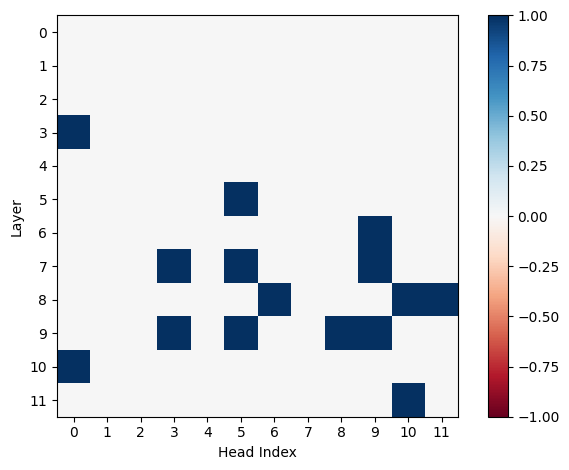

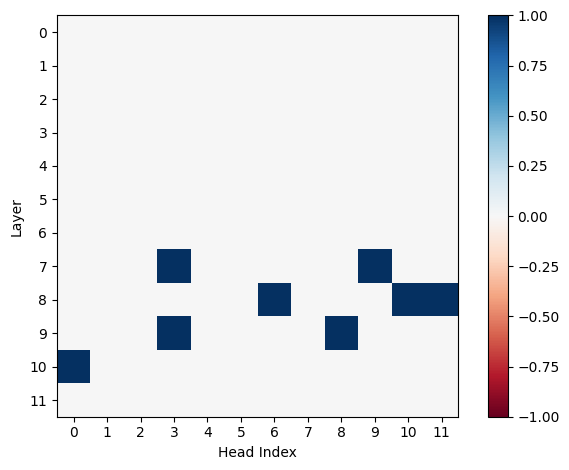

In [73]:
attn_important, attn_important_indices = highlight_components(attn_corrupt_clean, percentile=0.9)
mlp_important, mlp_important_indices = highlight_components(mlp_corrupt_clean, percentile=0.9)

attn_ablate, attn_ablate_indices = highlight_components(attn_corrupt_clean, percentile=0.95)
mlp_ablate, mlp_ablate_indices = highlight_components(mlp_corrupt_clean, percentile=0.95)

plot_attn(attn_important[0].int(), model)
plot_attn(attn_ablate[0].int(), model)

In [ ]:
# Ablate all important components
model.reset_hooks(including_permanent=True)

for _, layer, idx in attn_ablate_indices:
    def ablate_hook(act, hook, idx=idx):
        act[:, :, idx] = torch.zeros_like(act[:, :, idx])
        return act
    layer_name = get_act_name("result", layer)
    model.add_perma_hook(layer_name, ablate_hook)

for _, layer, idx in mlp_ablate_indices:
    def ablate_hook(act, hook, idx=idx):
        act[:, :, idx] = torch.zeros_like(act[:, :, idx])
        return act
    layer_name = get_act_name("post", layer)
    model.add_perma_hook(layer_name, ablate_hook)

In [65]:
mlp_corrupt_clean_knockout, attn_corrupt_clean_knockout = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(mlp_corrupt_clean_knockout, "results/case_study/mlp_corrupt_clean_knockout.pt")
torch.save(attn_corrupt_clean_knockout, "results/case_study/attn_corrupt_clean_knockout.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-6.2734e-06], device='cuda:0')

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-1.1683e-05], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([2.4512e-06], device='cuda:0')

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([3.2224e-07], device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([2.5807e-06], device='cuda:0')

Error (delta) for blocks.2.mlp.hook_post attribution: tensor([-5.4240e-06], device='cuda:0')

Error (delta) for blocks.3.attn.hook_result attribution: tensor([-2.1160e-06], device='cuda:0')

Error (delta) for blocks.3.mlp.hook_post attribution: tensor([5.5544e-06], device='cuda:0')

Error (delta) for blocks.4.attn.hook_result attribution: tensor([-1.0498e-05], device='cuda:0')

Error (delta) for blocks.4.mlp.hook_post attribution: tensor([1.4268e-06], device='cuda:0')

Error (delta) for blocks.5.attn.hook_result attri

### Analysis

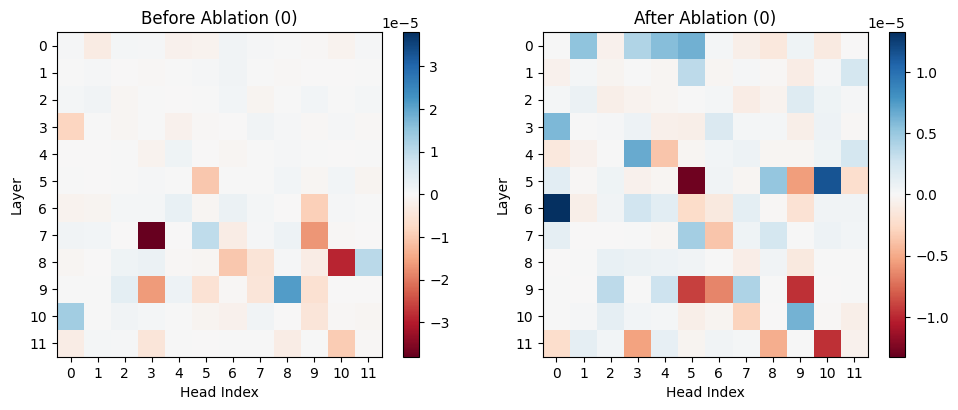

In [ ]:
plot_attn_comparison(attn_corrupt_clean, attn_corrupt_clean_knockout, model, "Before Ablation", "After Ablation")

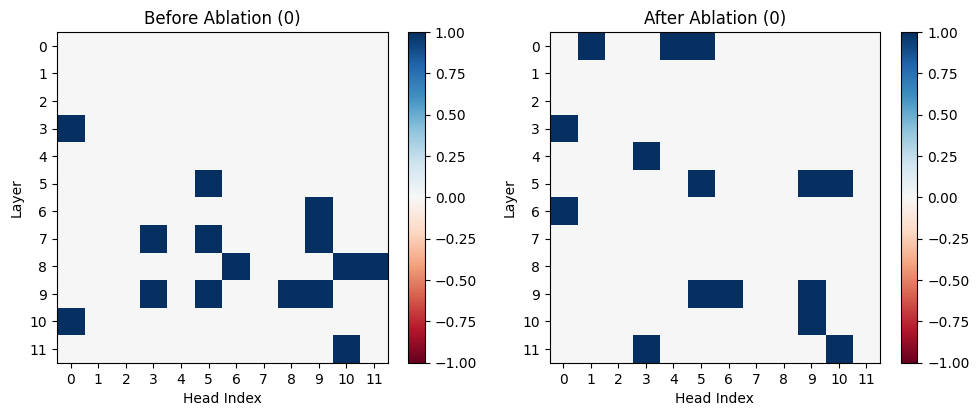

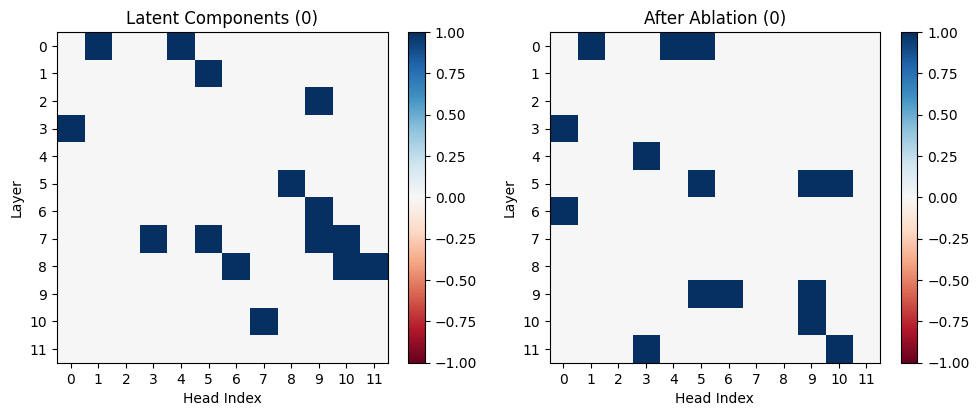

In [81]:
post_knockout_attn, post_knockout_attn_indices = highlight_components(attn_corrupt_clean_knockout)
post_knockout_mlp, post_knockout_mlp_indices = highlight_components(mlp_corrupt_clean_knockout)

plot_attn_comparison(attn_important.int(), post_knockout_attn.int(), model, "Before Ablation", "After Ablation")
plot_attn_comparison(latent_attn.int(), post_knockout_attn.int(), model, "Latent Components", "After Ablation")

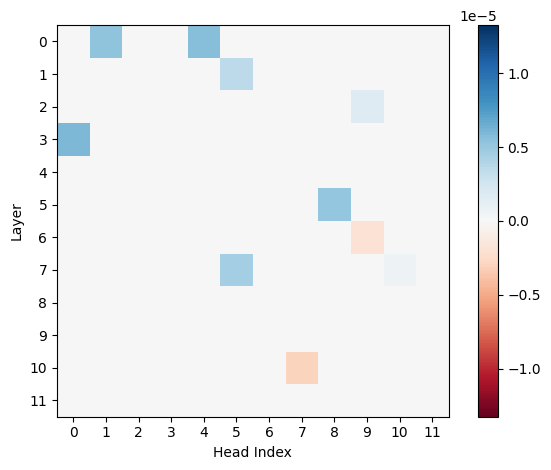

In [89]:
# Get new attribution scores for latent components
plot_attn(attn_corrupt_clean_knockout[0] * latent_attn[0], model, attn_corrupt_clean_knockout.abs().max())

In [ ]:
knockout_latent_attn_overlap = measure_overlap(post_knockout_attn, latent_attn)
print(f"Overlap between latent attention and post-knockout attention: {knockout_latent_attn_overlap.item()}")

knockout_latent_mlp_overlap = measure_overlap(post_knockout_mlp, latent_mlp)
print(f"Overlap between latent MLP and post-knockout MLP: {knockout_latent_mlp_overlap.item()}")

Overlap between latent attention and post-knockout attention: tensor([0.1111])
Overlap between latent MLP and post-knockout MLP: tensor([0.1707])


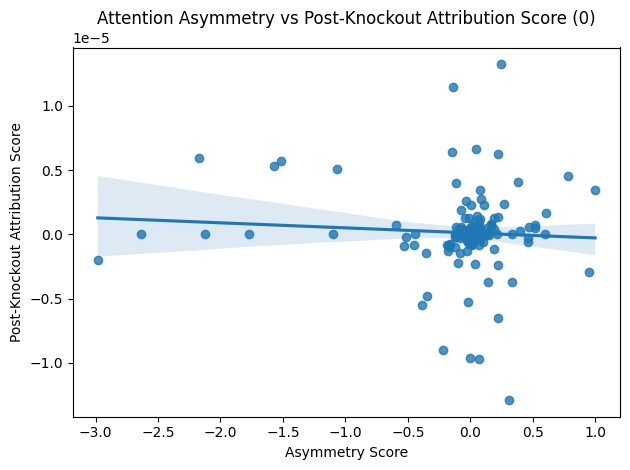

Correlation coefficient: -0.07058501885254223


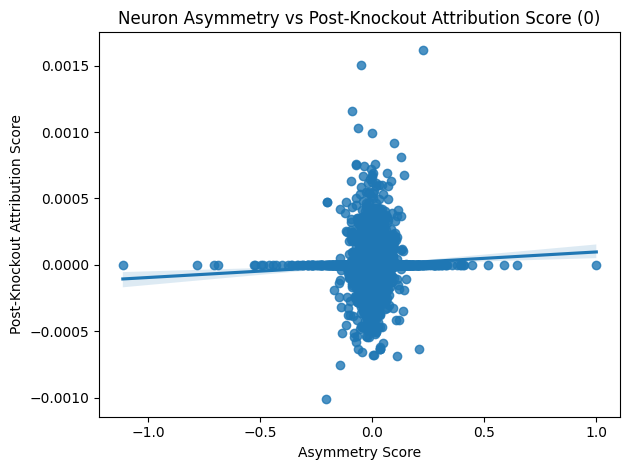

Correlation coefficient: 0.04154702335947775


In [93]:
# Plot correlation between asymmetry and post-knockout scores
plot_correlation(attn_asymmetry, attn_corrupt_clean_knockout, "Asymmetry Score", "Post-Knockout Attribution Score", "Attention Asymmetry vs Post-Knockout Attribution Score")
plot_correlation(mlp_asymmetry, mlp_corrupt_clean_knockout, "Asymmetry Score", "Post-Knockout Attribution Score", "Neuron Asymmetry vs Post-Knockout Attribution Score")

Conclusion: latent components detected using opposite patching directions, do not correspond to components with high attribution scores after knockout of primary circuit components.

## Pairwise ablation

We pick the latent component (6, 9), which has the highest difference in attribution scores, and ablate it alongside every significant component and latent component. For each ablated pair, we measure the logit difference to quantify the total effect on the model's output.